In [1]:
!nvidia-smi

Tue Oct  5 12:53:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.74       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P0    69W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import os
from pathlib import Path
from tqdm.auto import tqdm
import albumentations as A
from tqdm.contrib.concurrent import thread_map
from multiprocessing.dummy import freeze_support
from multiprocessing import RLock

from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

from sklearn.model_selection import train_test_split

import random
from tensorflow import keras
import numpy as np
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import layers
from random import shuffle

def list_dir_abs_path(path):
    path = Path(path)
    dirs = os.listdir(path)
    return list(map(lambda x: path/x, dirs))


from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/

Saving kaggle.json to kaggle (1).json
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [102]:
!kaggle datasets download -d masterokay/train-256
!unzip train-256.zip

  1% 32.0M/2.26G [00:01<02:06, 19.0MB/s]
User cancelled operation
Archive:  train-256.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of train-256.zip or
        train-256.zip.zip, and cannot find train-256.zip.ZIP, period.


In [39]:
batch_size = 32

img_size = (256, 256)
num_classes = 13
epochs = 100


optimizer = keras.optimizers.RMSprop(learning_rate=1e-3, rho=0.9, momentum=0.0, epsilon=1e-07,)


model_h5_name = "backupbackup_1e-3"
optimizer = keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07,)

In [58]:
resized_img_path = Path(f'/content/image')
resized_msk_path = Path(str(resized_img_path.resolve()) + "_mask")
imgs = os.listdir(resized_img_path)

In [91]:
add_parent_img_path = lambda p: resized_img_path/p
add_parent_msk_path = lambda p: resized_msk_path/p
resolve_path        = lambda p: str(p.resolve())
map_exists          = lambda p: p.exists()

input_img_paths = map(add_parent_img_path, imgs)
target_img_paths = map(add_parent_msk_path, imgs)

inputs_exists = all(map(map_exists, input_img_paths))
masks_exists  = all(map(map_exists, target_img_paths))

assert inputs_exists and masks_exists, f"{inputs_exists} & {masks_exists}"


input_img_paths = map(resolve_path, input_img_paths)
target_img_paths = map(resolve_path, target_img_paths)

input_output_paths = list(zip(input_img_paths, target_img_paths))
shuffle(input_output_paths)

train_data, val_data  = train_test_split(data, test_size=0.15)
train_input_img_paths, train_target_img_paths = list(zip(*train_data))
val_input_img_paths, val_target_img_paths = list(zip(*val_data))

#    batch_size, img_size, train_input_img_paths, train_target_img_paths
#)
#val_gen = SegmentationDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

print("#train_data:\t", len(train_data))
print("#val_data:\t", len(val_data))

#train_data:	 54
#val_data:	 10


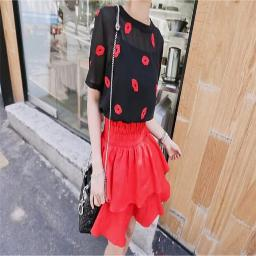

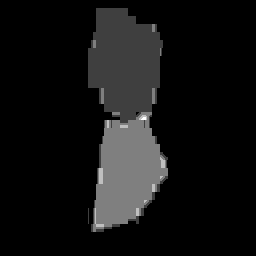

In [93]:
# Display input image #7
display(Image(filename=train_input_img_paths[9]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(train_target_img_paths[9]))
display(img)

In [94]:
def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### [First half of the network: downsampling inputs] ###

    # Entry block
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    # Blocks 1, 2, 3 are identical apart from the feature depth.
    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    ### [Second half of the network: upsampling inputs] ###

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # Project residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Add a per-pixel classification layer
    outputs = layers.Conv2D(num_classes, 3, activation="softmax", padding="same")(x)

    # Define the model
    model = keras.Model(inputs, outputs)
    return model


# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 32) 128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [95]:
class SegmentationDataset(keras.utils.Sequence):

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i: i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i: i + self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = img
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            # y[j] -= 1

        return x, y


In [96]:
# Instantiate data Sequences for each split
train_gen = SegmentationDataset(
    batch_size, img_size, train_input_img_paths, train_target_img_paths
)
val_gen = SegmentationDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [98]:
len(val_gen)

0

In [97]:
# Configure the model for training.
# We use the "sparse" version of categorical_crossentropy
# because our target data is integers.
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint(f"unet_segmentation_{model_h5_name}.h5", save_best_only=True, monitor='val_accuracy'),
    keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

# Train the model, doing validation at the end of each epoch.
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/100
1/1 [==============================] - 6s 6s/step - loss: 5.6044
Epoch 2/100
1/1 [==============================] - 1s 1s/step - loss: 7.8674
Epoch 3/100
1/1 [==============================] - 1s 1s/step - loss: 15.2258
Epoch 4/100
1/1 [==============================] - 1s 1s/step - loss: 9.1000


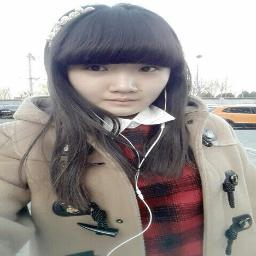

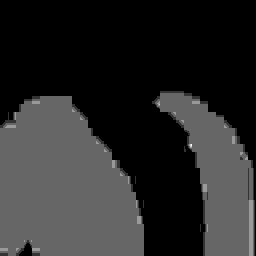

(256, 256)
(256, 256, 1)


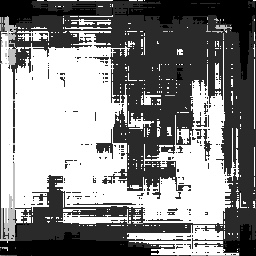

In [ ]:
# Generate predictions for all images in the validation set

#val_gen = SegmentationDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)
#val_preds = model.predict(val_gen)
val_preds = model.predict(train_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    print(mask.shape)
    mask = np.expand_dims(mask, axis=-1)
    print(mask.shape)
    img = PIL.ImageOps.autocontrast(keras.preprocessing.image.array_to_img(mask))
    display(img)


# Display results for validation image #10
i = 0#min(10, val_samples - 1)

# Display input image
display(Image(filename=val_input_img_paths[i]))

# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
#display_mask(i)  # Note that the model only sees inputs at 150x150.
display_mask(i)